In [1]:
import matplotlib.pyplot as plt
import zipfile
with zipfile.ZipFile('/content/main.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [2]:
import timeit
import cv2 
import os
import sys
import numpy as np
from model1 import resolve_single
from utils import load_image, plot_sample
from model1.srgan import generator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import save_img

start = timeit.default_timer()
model = generator()
model.load_weights('weights/srgan/gan_generator.h5')

In [ ]:
CATEGORIES = ["data"]
for category in CATEGORIES :
    path = os.path.join(category)
    for img in os.listdir(path):
      try :
        lr = load_image("data/"+img)
        sr = resolve_single(model, lr)
        l="/content/data_sr"+"/"+img
        img1 = save_img(l, sr)
      except Exception as e:
        pass

In [4]:
!pip install keras==2.4.3
!pip install tensorflow==2.4.1

  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires keras<2.9,>=2.8.0rc0, but you have keras 2.4.3 which is incompatible.


     |████████████████████████████████| 394.3 MB 13 kB/s 
     |████████████████████████████████| 2.9 MB 36.5 MB/s 
     |████████████████████████████████| 3.8 MB 36.5 MB/s 
     |████████████████████████████████| 132 kB 55.8 MB/s 
     |████████████████████████████████| 462 kB 46.6 MB/s 
     |████████████████████████████████| 14.8 MB 35.2 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68723 sha256=81eacaa8179a964d09aeddfbca13fddcfc25939eede697a02e18146238955403
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  A

In [1]:
import matplotlib.pyplot as plt
import zipfile
with zipfile.ZipFile('/content/data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [2]:
import os
from imutils import paths
import imageio

import numpy as np
from tqdm import tqdm
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from model import ResNetUNet
from utilities import reverse_transform, reverse_transform_mask
from preprocess import check_dir

WEIGHT_PATH = "/content"
USE_BEST_VAL = True
DISPLAY_PLOTS = False
TEST_DIR = "/content/data_sr/"
SAVE_PATH = "/content/data_seg"
PREFIX = "seg_"

trans = transforms.Compose([
    transforms.ToTensor()
])


class parseTestset(Dataset):
    def __init__(self, img_paths, transform=None):
        self.img_paths = img_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        image_path = self.img_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))

        _, filename = os.path.split(image_path)

        if self.transform:
            image = self.transform(image)  # ToTensor
            image = transforms.Normalize(  # TODO: remove this?
                [0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])(image)
        return image, filename


if __name__ == "__main__":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f'running on: {device}')

    num_class = 1
    model = ResNetUNet(num_class).to(device)

    if USE_BEST_VAL:
        model.load_state_dict(torch.load(
            os.path.join(WEIGHT_PATH, "pre.pth"),map_location ='cpu'))
    else:
        model.load_state_dict(torch.load(
            os.path.join(WEIGHT_PATH, "latest_weights.pth")))

    test_img_paths = list(paths.list_images(TEST_DIR))
    print(f'found {len(test_img_paths)} images')

    # small batch_size if you are testing on 1 or 2 images
    b_size = min(25, len(test_img_paths))

    test_set = parseTestset(test_img_paths, transform=trans)
    test_loader = DataLoader(test_set, batch_size=b_size,
                             shuffle=True, num_workers=0)

    check_dir(SAVE_PATH)

    model.eval()
    for i, batch_pair in enumerate(tqdm(test_loader)):
        img_batch = batch_pair[0].to(device)
        img_names = batch_pair[1]

        seg_batch = model(img_batch)
        seg_batch = torch.sigmoid(seg_batch)
        for img, seg, filename in zip(img_batch, seg_batch, img_names):
            seg_np = seg.cpu().detach()
            seg_np = reverse_transform_mask(seg_np)
            seg_np = np.where(seg_np > 220, 1, 0)

            img_np = img.cpu()
            img_np = reverse_transform(img_np)
            prod_img = np.multiply(seg_np, img_np).astype("uint8")

            if len(PREFIX) > 0:
                filename = filename

            savename = os.path.join(SAVE_PATH, filename)
            imageio.imwrite(savename, prod_img)

running on: cpu
found 25 images
'/content/data_seg' folder already exists.


100%|██████████| 1/1 [01:31<00:00, 91.47s/it]


In [4]:
#!pip uninstall tensorflow
#!pip install tensorflow-gpu
training_data = []
import pandas as pd
import IPython.display as display
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os,random
import pickle
import matplotlib.pyplot as plt
print(tf.__version__)
IMAGE_HEIGHT=224
IMAGE_WIDTH=224
BATCH_SIZE=10
def get_pathframe(path):
  '''
  Get all the images paths and its corresponding labels
  Store them in pandas dataframe
  '''
  filenames = os.listdir(path)
  categories = []
  paths=[]
  for filename in filenames:
    paths.append(path+filename)
    category = filename.split('.')[0]
    if category == 'ng':
      categories.append(1)
      x=1
    else:
      categories.append(0)
      x=0
    img_array = cv2.imread(path+filename, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (224, 224))
    training_data.append([new_array, x])

  df= pd.DataFrame({
      'filename': filenames,
      'category': categories,
      'paths':paths
  })
  return df

df=get_pathframe("data_seg/")
df.tail(20)
X = [] #features
y = [] #labels

for features, label in training_data:
	X.append(features)
	y.append(label)

X = np.array(X).reshape(-1, 224, 224, 1)

# Creating the files containing all the information about your model
pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

pickle_in = open("X.pickle", "rb")
X = pickle.load(pickle_in)

2.4.1


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
IMAGE_HEIGHT=224
IMAGE_WIDTH=224
BATCH_SIZE=2

def load_and_preprocess_image(path):
  '''
  Load each image and resize it to desired shape
  '''
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
  image /= 255.0  # normalize to [0,1] range
  return image

def convert_to_tensor(df):
  '''
  Convert each data and labels to tensor
  '''
  path_ds = tf.data.Dataset.from_tensor_slices(df['paths'])
  image_ds = path_ds.map(load_and_preprocess_image)
  #onehot_label=tf.one_hot(tf.cast(df['category'], tf.int64),2)
  onehot_label=tf.cast(df['category'], tf.int64)
  label_ds = tf.data.Dataset.from_tensor_slices(onehot_label)

  return image_ds,label_ds

X,Y=convert_to_tensor(df)
print("Shape of X in data:", X)
print("Shape of Y in data:", Y)

Shape of X in data: <MapDataset shapes: (224, 224, 3), types: tf.float32>
Shape of Y in data: <TensorSliceDataset shapes: (), types: tf.int64>


In [ ]:
dataset=tf.data.Dataset.zip((X,Y)).shuffle(buffer_size=20)
dataset_train=dataset.take(7)
dataset_test=dataset.skip(7)

dataset_train=dataset_train.batch(BATCH_SIZE, drop_remainder=True)
dataset_test=dataset_test.batch(BATCH_SIZE, drop_remainder=True)
dataset_train

def plotimages(imagesls):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for image,ax in zip(imagesls, axes):
    ax.imshow(image)
    ax.axis('off')

imagesls=[]
for n, image in enumerate(X.take(5)):
  imagesls.append(image)

plotimages(imagesls)

from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")

for layer in base_model.layers:
    layer.trainable = False

from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
import keras
base_model = Sequential()
base_model.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
base_model.add(Dense(2, activation='sigmoid'))
# Compiling the model using some basic parameters
base_model.compile(loss="sparse_categorical_crossentropy",
				optimizer="adam",
				metrics=["accuracy"])
#base_model.compile(optimizer = keras.optimizers.adam(lr=0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
resnet_history = base_model.fit(dataset_train, validation_data = dataset_test, steps_per_epoch = 1, epochs = 5)

base_model.save_weights("resmodel.h5")
base_model.save('CNN1.model')
print(resnet_history)

def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
plot_model_history(resnet_history)


loss, accuracy = base_model.evaluate_generator(dataset_test)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))



In [ ]:
import sys
import os

import tensorflow as tf

CATEGORIES = ["glaucoma","no_glaucoma"]
path = "/content/data_seg/g.2324.jpg"
image = tf.io.read_file(path)
image = tf.image.decode_jpeg(image, channels=3)
image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
image /= 255.0
image_x=tf.expand_dims(image,axis=0)
model=tf.keras.models.load_model('CNN1.model')
y=model.predict(image_x)
prediction = list(y[0])
print(prediction)
print(CATEGORIES[prediction.index(max(prediction))])

Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.7032 - accuracy: 0.3636 - val_loss: 0.6313 - val_accuracy: 0.6667
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.6260 - accuracy: 0.5909 - val_loss: 0.6805 - val_accuracy: 0.6667
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.5689 - accuracy: 0.5909 - val_loss: 0.6721 - val_accuracy: 0.6667
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.4569 - accuracy: 0.7727 - val_loss: 0.7028 - val_accuracy: 0.6667
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.3785 - accuracy: 0.9091 - val_loss: 0.7406 - val_accuracy: 0.6667
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.2640 - accuracy: 0.9545 - val_loss: 0.8433 - val_accuracy: 0.6667
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.1577 - accuracy: 0.9545 - val_loss: 0.8191 - val_accuracy: 0.6667
Epoch 8/10
1/1 [=========================

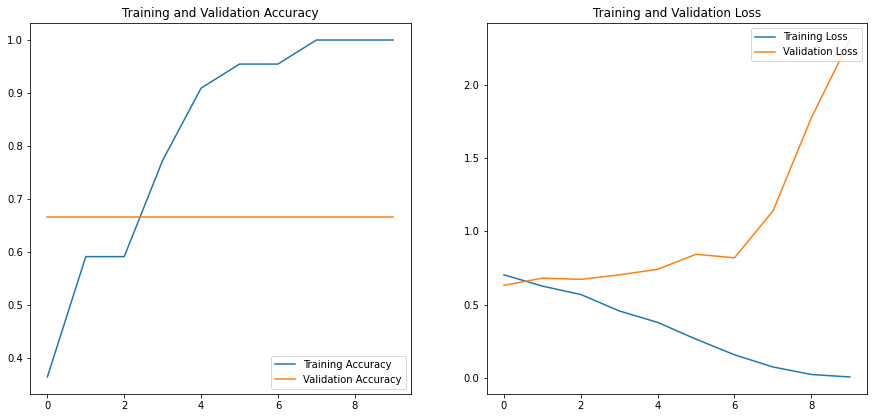

In [5]:
import tensorflow as tf 
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import pickle
from keras.models import model_from_json
from keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
# Opening the files about data
X = pickle.load(open("X.pickle", "rb"))
y = pickle.load(open("y.pickle", "rb"))

# normalizing data (a pixel goes from 0 to 255)
X = X/255.0

# Building the model
model = Sequential()
# 3 convolutional layers
model.add(Conv2D(32, (3, 3), input_shape = X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2 hidden layers
model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))

model.add(Dense(128))
model.add(Activation("relu"))

# The output layer with 13 neurons, for 13 classes
model.add(Dense(2))
model.add(Activation("softmax"))

# Compiling the model using some basic parameters
model.compile(loss="sparse_categorical_crossentropy",
				optimizer="adam",
				metrics=["accuracy"])
y=np.array(y)
# Training the model, with 40 iterations
# validation_split corresponds to the percentage of images used for the validation phase compared to all the images
history = model.fit(X, y, batch_size=64, epochs=10, validation_split=0.1)

# Saving the model
model_json = model.to_json()
with open("model.json", "w") as json_file :
	json_file.write(model_json)

model.save_weights("model.h5")
print("Saved model to disk")

model.save('CNN.model')

# Printing a graph showing the accuracy changes during the training phase
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
acc=np.array(acc)
val_acc=np.array(val_acc)
loss=np.array(loss)
val_loss=np.array(val_loss)
epochs_range = range(10)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [9]:
import cv2
import tensorflow as tf
x=0
y=0
CATEGORIES = ["glaucoma","no_glaucoma"]
def prepare(file):
    img_array = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    #img_array = cv2.Canny(img_array, threshold1=3, threshold2=10)
    #img_array = cv2.medianBlur(img_array,1)
    new_array = cv2.resize(img_array, (224, 224))
    return new_array.reshape(-1, 224, 224, 1)
model = tf.keras.models.load_model("CNN.model")
image = "/content/data_seg/g.2397.jpg" #your image path
prediction = model.predict(prepare(image))
prediction = list(prediction[0])
print(prediction)
print(CATEGORIES[prediction.index(max(prediction))])

[1.0, 0.0]
glaucoma
